# Movie Lens Database

MovieLens data sets were collected by the GroupLens Research Project at the University of Minnesota.
 
This data set consists of:
* 100,000 ratings (1-5) from 943 users on 1682 movies. 
* Each user has rated at least 20 movies. 
* Simple demographic info for the users (age, gender, occupation, zip)

The data was collected through the MovieLens web site (movielens.umn.edu) during the seven-month period from September 19th, 
1997 through April 22nd, 1998. This data has been cleaned up - users who had less than 20 ratings or did not have complete demographic information were removed from this data set. Detailed descriptions of the data file can be found at the end of this file.

### Problem Statement: 

Based on the given data, we need to find
* Which predictors are significant in predicting the rating of a movie
* How well those predictors describe the rating of a movie

We split the data into training and testing sets, then use <b>Ridge and Lasso Regression</b> algorithms to fit the training data to create models, and then test it on the testing data to evaluate the models

## Step 1: Importing and combining datasets

In [196]:
# import required libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error

from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [197]:
#import of review data
cols = ["user id","item id","rating","timestamp"]
#encoding using ISO-8859-1 is used because utf-8 does not support all the characters in movie names
df_data = pd.read_csv("ml-100k/u.data",sep="\t",names=cols,header=None,encoding="ISO-8859-1")
df_data.head()

,user id,item id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [198]:
#import of moviedata
cols = ["movie id","movie title","release date","video release date","IMDb URL","unknown",
        "Action","Adventure","Animation","Childrens","Comedy","Crime","Documentary",
        "Drama","Fantasy","Film-Noir","Horror","Musical","Mystery","Romance","Sci-Fi",
        "Thriller","War","Western"]

df_movie = pd.read_csv("ml-100k/u.item",sep="|",names=cols,header=None,encoding="ISO-8859-1")
df_movie.head()

,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Childrens,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [199]:
#import of user data
cols = ["user id","age","gender","occupation","zip code"]
df_user = pd.read_csv("ml-100k/u.user",sep="|",names=cols,header=None,encoding="ISO-8859-1")
df_user.head()

,user id,age,gender,occupation,zip code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [200]:
#frequency binning the ages into age groups as it will be easier for future analysis
df_user['age_group'] = pd.qcut(df_user['age'],q=10,precision=0)

In [201]:
#join all three dataframes

df = pd.merge(pd.merge(df_data,
                  df_user[["user id",
                           "age_group",
                           "gender",
                           "occupation"]],
                  on='user id',
                  how='left'),
              df_movie,
              left_on = 'item id',
              right_on = 'movie id',
              how ='left')
df.head()

,user id,item id,rating,timestamp,age_group,gender,occupation,movie id,movie title,release date,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,196,242,3,881250949,"(46.0, 51.0]",M,writer,242,Kolya (1996),24-Jan-1997,...,0,0,0,0,0,0,0,0,0,0
1,186,302,3,891717742,"(35.0, 40.0]",F,executive,302,L.A. Confidential (1997),01-Jan-1997,...,0,1,0,0,1,0,0,1,0,0
2,22,377,1,878887116,"(23.0, 26.0]",M,writer,377,Heavyweights (1994),01-Jan-1994,...,0,0,0,0,0,0,0,0,0,0
3,244,51,2,880606923,"(26.0, 29.0]",M,technician,51,Legends of the Fall (1994),01-Jan-1994,...,0,0,0,0,0,1,0,0,1,1
4,166,346,1,886397596,"(46.0, 51.0]",M,educator,346,Jackie Brown (1997),01-Jan-1997,...,0,0,0,0,0,0,0,0,0,0


In [202]:
#drop unneccessary features
df.drop(["movie id",
        "movie title",
        "release date",
        "video release date",
        "IMDb URL",
        "unknown",
        "user id",
        "item id",
        "timestamp"],axis=1, inplace=True)
df.head()

,rating,age_group,gender,occupation,Action,Adventure,Animation,Childrens,Comedy,Crime,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,3,"(46.0, 51.0]",M,writer,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,3,"(35.0, 40.0]",F,executive,0,0,0,0,0,1,...,0,1,0,0,1,0,0,1,0,0
2,1,"(23.0, 26.0]",M,writer,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,2,"(26.0, 29.0]",M,technician,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,1
4,1,"(46.0, 51.0]",M,educator,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


## Step 2: Data Cleaning and Categorizing

In [203]:
# check for null values
df.isnull().sum()

rating         0
age_group      0
gender         0
occupation     0
Action         0
Adventure      0
Animation      0
Childrens      0
Comedy         0
Crime          0
Documentary    0
Drama          0
Fantasy        0
Film-Noir      0
Horror         0
Musical        0
Mystery        0
Romance        0
Sci-Fi         0
Thriller       0
War            0
Western        0
dtype: int64

In [204]:
#categorize age_group, gender and occupation using 1-hot encoder
df['age_group'] = pd.Categorical(df['age_group'])
df['gender'] = pd.Categorical(df['gender'])
df['occupation'] = pd.Categorical(df['occupation'])

age_group_dummies = pd.get_dummies(df['age_group'])
gender_dummies = pd.get_dummies(df['gender'])
occupation_dummies = pd.get_dummies(df['occupation'])

df = pd.concat([df,
                age_group_dummies,
                gender_dummies,
                occupation_dummies], axis=1)

df.drop(['age_group',
        'gender',
        'occupation'], axis=1, inplace=True)
df.head()

,rating,Action,Adventure,Animation,Childrens,Comedy,Crime,Documentary,Drama,Fantasy,...,marketing,none,other,programmer,retired,salesman,scientist,student,technician,writer
0,3,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,3,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,2,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
4,1,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [205]:
# check final dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 52 columns):
rating           100000 non-null int64
Action           100000 non-null int64
Adventure        100000 non-null int64
Animation        100000 non-null int64
Childrens        100000 non-null int64
Comedy           100000 non-null int64
Crime            100000 non-null int64
Documentary      100000 non-null int64
Drama            100000 non-null int64
Fantasy          100000 non-null int64
Film-Noir        100000 non-null int64
Horror           100000 non-null int64
Musical          100000 non-null int64
Mystery          100000 non-null int64
Romance          100000 non-null int64
Sci-Fi           100000 non-null int64
Thriller         100000 non-null int64
War              100000 non-null int64
Western          100000 non-null int64
(6.0, 20.0]      100000 non-null uint8
(20.0, 23.0]     100000 non-null uint8
(23.0, 26.0]     100000 non-null uint8
(26.0, 29.0]     100000 non-null

#### All columns are now non-null and numerical

## Step 3: Data Visualization

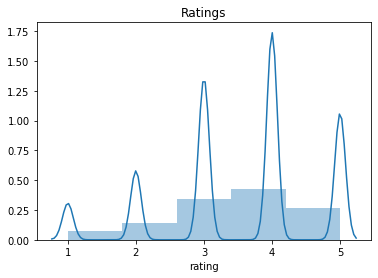

In [206]:
# plot response histogram
plt.title('Ratings')
sns.distplot(df['rating'], bins=5)
plt.show()

## Step 4: Splitting Data

In [207]:
y = df.rating
x = df.drop('rating',axis=1)

# split data into 70% (training set) and 30% (testing set)
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3)

## Step 5: Regression

In [208]:
# set array for alpha (λ) in the range (0.000001, 10000)
alpha = []
for i in range(7):
    alpha.extend(np.arange(10**(i-5), 10**(i-4), 10**(i-5)*2))
parameters = {'alpha': alpha}
# alpha

* ## Ridge Regression 

In [209]:
# using GridSeachCV for 10-fold cross validation
ridge = Ridge()

ridge_cv = GridSearchCV(estimator = ridge, 
                        param_grid = parameters, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = 10, 
                        return_train_score=True,
                        verbose = 1)   

ridge_cv.fit(x_train, y_train) 

Fitting 10 folds for each of 35 candidates, totalling 350 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:  1.4min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [1e-05, 3.0000000000000004e-05,
                                   5.000000000000001e-05, 7.000000000000002e-05,
                                   9.000000000000002e-05, 0.0001,
                                   0.00030000000000000003,
                                   0.0005000000000000001, 0.0007000000000000001,
                                   0.0009000000000000002, 0.001, 0.003, 0.005,
                                   0.007, 0.009000000000000001, 0.01, 0.03,
                                   0.049999999999999996, 0.06999999999999999,
                                   0.08999999999999998, 0.1,
                                   0.3000000000000000

In [210]:
# best value of alpha
ridge_cv.best_estimator_

Ridge(alpha=1e-05, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [211]:
# train model with above alpha and get mean squared error
best_alpha = 1e-05
ridge_alpha = Ridge(alpha=best_alpha)
ridge_alpha.fit(x_train, y_train)

mse_ridge = mean_squared_error(y_test, ridge_alpha.predict(x_test))

### Find top 15 predictors influencing the response the most

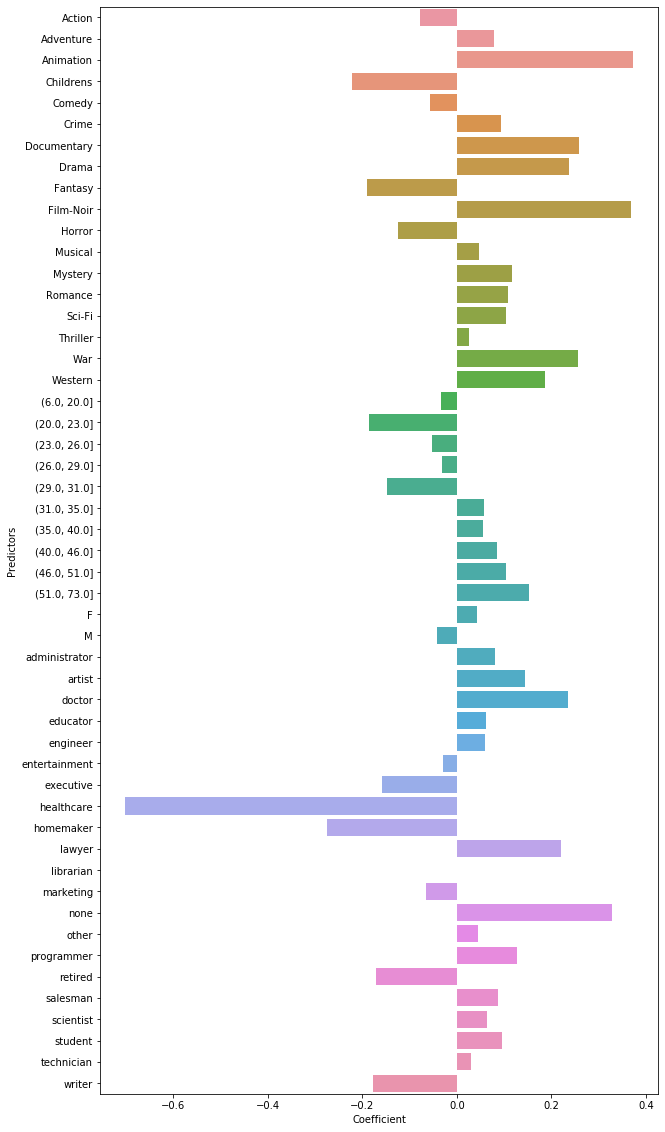

In [212]:
# Barplot for all features

ridge_df = pd.DataFrame({'Predictors':x_train.columns, 'Coefficient':ridge_alpha.coef_.round(4)})
ridge_df.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots(figsize=[10,20])
sns.barplot(y='Predictors', x='Coefficient', ax=ax, data=ridge_df)

#### Check if any predictors have been eliminated

In [213]:
ridge_elim = (ridge_df.Coefficient == float(0)).sum()
print("Ridge eliminated", ridge_elim, "predictors!")

Ridge eliminated 0 predictors!


In [214]:
# eliminating predictors with low coefficient 
ridge_df.sort_values(by = 'Coefficient', ascending=False, inplace=True)
ridge_df.reset_index(inplace = True, drop = True)

# pick top 15 predictors out of original 51
ridge_df = ridge_df.iloc[:15]
ridge_df

,Predictors,Coefficient
0,Animation,0.3720
1,Film-Noir,0.3693
2,none,0.3283
3,Documentary,0.2581
4,War,0.2556
5,Drama,0.2374
6,doctor,0.2345
7,lawyer,0.2211
8,Western,0.1868
9,"(51.0, 73.0]",0.1516


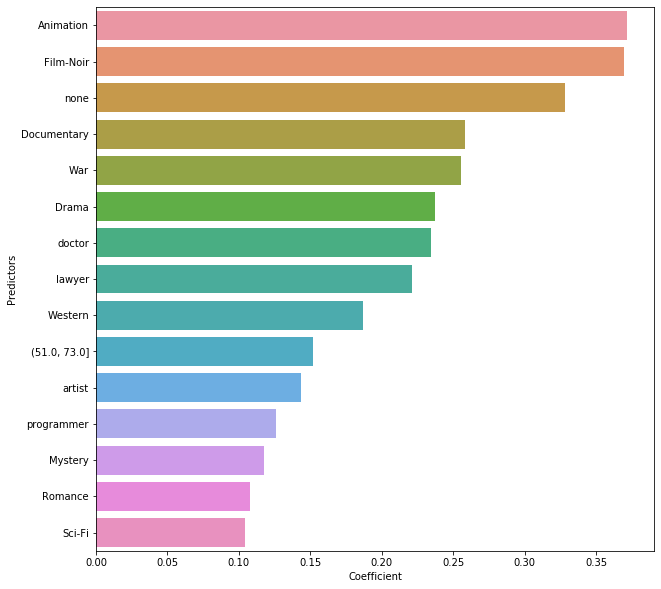

In [215]:
# plot top predictors
fig, ax = plt.subplots(figsize=[10,10])
sns.barplot(y='Predictors', x='Coefficient', ax=ax, data=ridge_df)

* ## Lasso Regression 

In [216]:
# using GridSeachCV for 5-fold cross validation
lasso = Lasso()

lasso_cv = GridSearchCV(estimator = lasso, 
                        param_grid = parameters, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = 5, 
                        return_train_score=True,
                        verbose = 1)   

lasso_cv.fit(x_train, y_train) 

Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\samre\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 296.16350741832866, tolerance: 7.112496198214291
  positive)
[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:  2.1min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [1e-05, 3.0000000000000004e-05,
                                   5.000000000000001e-05, 7.000000000000002e-0...
                                   0.0005000000000000001, 0.0007000000000000001,
                                   0.0009000000000000002, 0.001, 0.003, 0.005,
                                   0.007, 0.009000000000000001, 0.01, 0.03,
                                   0.049999999999999996, 0.06999999999999999,
                                   0.08999999999999998, 0.1,
                                   0.30000000000000004, 0.5000000000000001,
               

In [217]:
# best value of alpha
lasso_cv.best_estimator_

Lasso(alpha=1e-05, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [218]:
# train model with above alpha and get mean squared error
best_alpha = 1e-05
lasso_alpha = Lasso(alpha=best_alpha)
lasso_alpha.fit(x_train, y_train)

mse_lasso = mean_squared_error(y_test, lasso_alpha.predict(x_test))

### Find top 15 predictors influencing the response the most

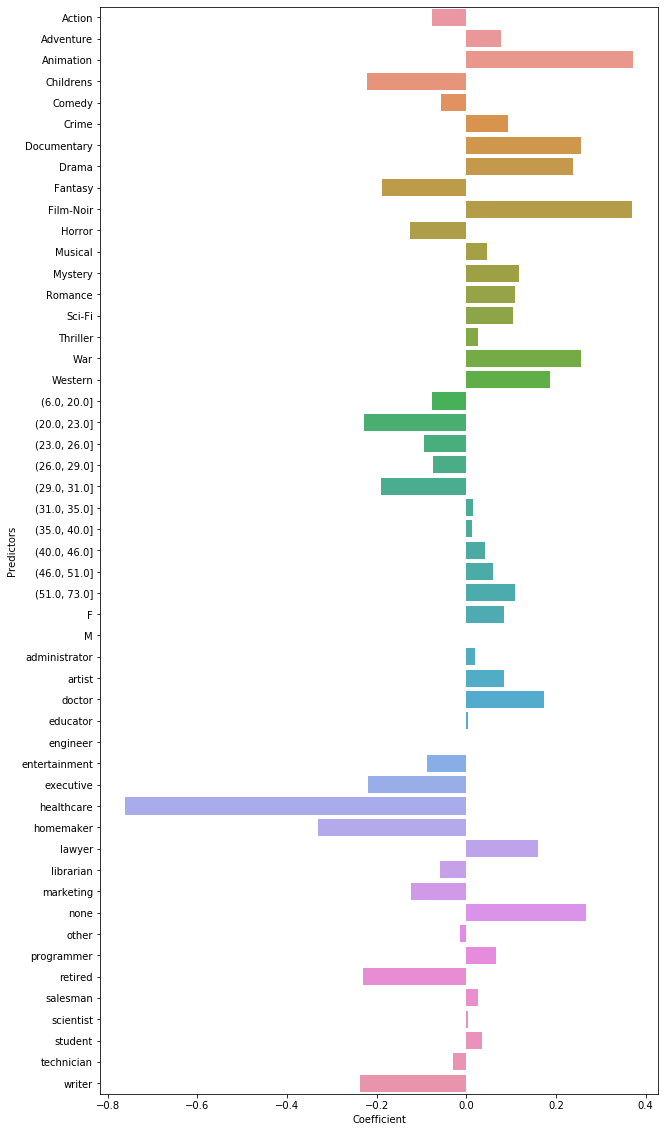

In [219]:
# Barplot for all features

lasso_df = pd.DataFrame({'Predictors':x_train.columns, 'Coefficient':lasso_alpha.coef_.round(4)})
lasso_df.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots(figsize=[10,20])
sns.barplot(y='Predictors', x='Coefficient', ax=ax, data=lasso_df)

#### Check if any predictors have been eliminated

In [220]:
lasso_elim = (lasso_df.Coefficient == float(0)).sum()
print("Lasso eliminated", lasso_elim, "predictors!")

Lasso eliminated 2 predictors!


In [221]:
# eliminating predictors with low coefficient 
lasso_df.sort_values(by = 'Coefficient', ascending=False, inplace=True)
lasso_df.reset_index(inplace = True, drop = True)

# pick top 15 predictors out of original 51
lasso_df = lasso_df.iloc[:15]
lasso_df

,Predictors,Coefficient
0,Animation,0.3714
1,Film-Noir,0.3688
2,none,0.2674
3,Documentary,0.2566
4,War,0.2555
5,Drama,0.2373
6,Western,0.1861
7,doctor,0.1731
8,lawyer,0.1607
9,Mystery,0.1171


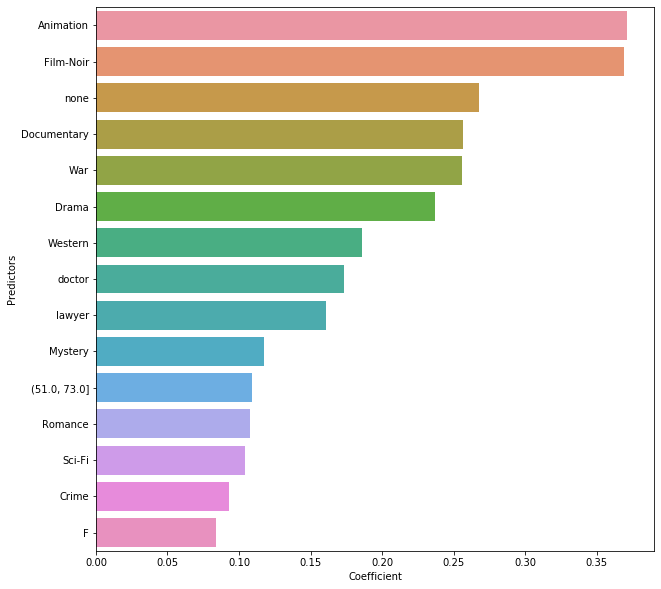

In [222]:
# plot top predictors
fig, ax = plt.subplots(figsize=[10,10])
sns.barplot(y='Predictors', x='Coefficient', ax=ax, data=lasso_df)

In [223]:
# compare errors of both methods
print("MSE Ridge:", mse_ridge, "\nMSE Lasso:", mse_lasso)
print("\nNumber of predictors eliminated:\nRidge:", ridge_elim, "\nLasso:", lasso_elim)

MSE Ridge: 1.2103936791098615 
MSE Lasso: 1.2103793368475615

Number of predictors eliminated:
Ridge: 0 
Lasso: 2


### Conclusion: Method with lower MSE and more number of predictors eliminated is Lasso Regression